In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as K
import matplotlib.pyplot as plt
import random 
import math
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(42); tf.random.set_seed(42); random.seed(42)

# Dataset
## Image Generator

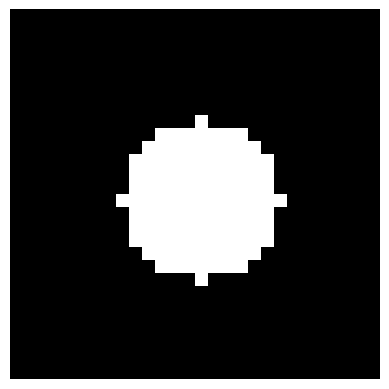

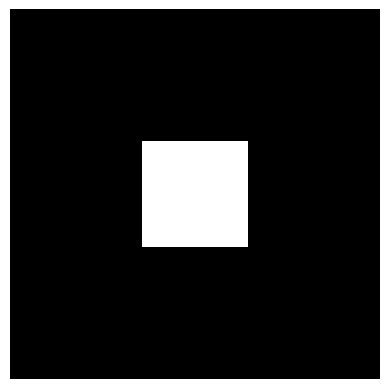

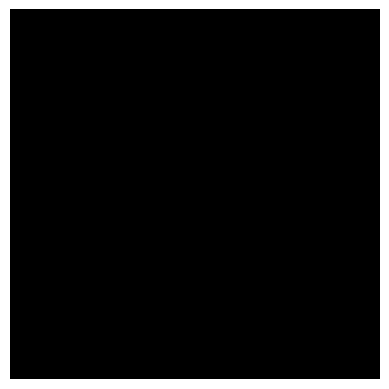

In [3]:
##IMAGE GENERATOR 
def make_square(h=28, w=28, size=8):
    img = np.zeros((h,w), dtype=np.float32)
    y0 = h//2 - size//2; x0 = w//2 - size//2
    img[y0:y0+size, x0:x0+size] = 1.0
    return img
    
def make_circle(h=28, w=28, r=6):
    yy, xx = np.mgrid[:h, :w]
    cy, cx = h//2, w//2
    return ((yy-cy)**2 + (xx-cx)**2 <= r*r).astype(np.float32)

IMG_C = make_circle()
IMG_S = make_square()
IMG__ = np.zeros_like(IMG_C, dtype=np.float32)  # blank / PAD

#Show Circle
plt.imshow(IMG_C, cmap="gray")  
plt.axis("off")               
plt.show()

#Show Square
plt.imshow(IMG_S, cmap="gray")  
plt.axis("off")               
plt.show()

#Show Blank 
plt.imshow(IMG__, cmap="gray")  
plt.axis("off")               
plt.show()



## Inputs Functons (timing/padding) 

In [4]:
##Inputs functions 
def expand_events(events, dt_min=0.05, dt_max=0.2, rng=None): #frame simulate 5-20 Hz 
    """
    Expand my sequence of events into per-frame images and per-frame durations.

    Args:
        events (list[tuple[np.ndarray, float]]): Sequence of (image, duration_seconds) pairs. Durations are in seconds (float).
        dt_min (float): Minimum per-frame time step in seconds. Default = 0.05 sec
        dt_max (float): Maximum per-frame time step in seconds. Default = 0.2 sec
        rng (np.random.Generator): Numpy generator used to sample dt in [dt_min, dt_max].

    Returns:
        frames (np.ndarray):
            Image sequence tensor of shape (T, H, W, C). number of frames * frame height * frame width * channels 
            If input images are (H, W), a channel axis is added so C = 1.
        dts (np.ndarray):
            Per-frame durations (seconds) tensor, shape (T, 1), such that for each event,
            the sum of its chunk of dts equals the event duration up to floating error.

    Notes:
        - T (the number of frames) depends on total duration and the sampled dt’s:
            approx T ≈ total_duration / mean(dt).
        - Effective frame rate is between 1/dt_max and 1/dt_min Hz.
        - The final dt of each event is clipped so cumulative time matches the
          event duration exactly.
    """
    
    if rng is None:
        raise ValueError("expand_events requires an rng passed from make_dataset_with_gaps")
        
    frames, dts = [], [] # shape (T, 28, 28, 1); images at each timesteps where T is the sequence length (total number of timesteps(frames))
                            # shape (T, 1); duration of each frames
    for img, dur in events: #for each (images, durations) ex: (IMG_C, 2.0)
        t_remain = dur
        while t_remain > 1e-6:  
            dt = rng.uniform(dt_min, dt_max) # making frame count not equal to duration, thus the model must integrate elapsed time, i.e., sum of dt = real duration.
                                                    #If we change sample rate, the model can still understand time; more like neurons work. 
            if dt > t_remain:  #make last step fits remaining duration 
                dt = t_remain
           
            frames.append(img[..., None])   # save 1 frame of my 2D image (28x28) + 1 dimension at the end to fit ML frameworks (28,28,1)
            dts.append([dt])                # save the duration of the frame, shape (T,1) [ [], [], ... ] to know the exact elapsed time, since number of frames doesn't equal duration 
            t_remain -= dt
    return np.stack(frames,0), np.array(dts, np.float32) #Proper time-series tensor on the 0 axis: time x height x width x channels (T, 28, 28, 1)
                                                          #and turn the list into an array so it can fed into a neural net 
                                                           #for exemple, a sequence of 500 frames with our square and cirle 28x28 is (500, 28, 28, 1) with channel 1 and its corresponding dts. 



def pad_sequence(frames, dts, T_max=1000): 
    """
    After using expand_events(), allows my sequences to be all of the same lenght by padding to length T_max so it can be batched for training.

    Args:
        frames (np.ndarray): sequence of images frames (seconds) intersected by gaps (seconds).
        dts (np.ndarray):
        T_max (int): Max length of the sequence. Default = 1000 frames/timesteps

    Returns:
        X (np.ndarray): my frames tensor.
        D (np.ndarray): my dts tensor.
        
    """
    T = frames.shape[0]
    X = np.zeros((T_max,28,28,1), np.float32) #Create a zeros array, hardcoded for my 28x28 pictures. 
    D = np.zeros((T_max,1), np.float32)
    X[:T] = frames  #Fill X with my frames and the rest is from T to T_max 
    D[:T] = dts     
    return X,D

## Bins Dataset Functions (labels/outputs)

In [5]:
#DATESET BINS 

#Create my bins intervals 
EDGES_A = np.array([1.0, 2.0, 3.0, 4.0, 5.0])            # 4 bins: [1,2), [2,3), [3,4), [4,5)
EDGES_B = np.array([1.0, 2.0, 3.0])                      # 2 bins: [1,2), [2,3)
EDGES_C = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])  # 6 bins: [1,2),...[6,7)

#Get the lenght of my bins interval 
NA = len(EDGES_A) - 1  # 4
NB = len(EDGES_B) - 1  # 2
NC = len(EDGES_C) - 1  # 6
N_CLASSES = NA * NB * NC  # 48 classifications possible in total 

def bin_index(gap_length, edges):
    """
    This function allows me to find in which bin my specific gap(seconds) is ending in. 

    Args:
        gap_length (float): Lenght of my gap in seconds. 
        edges (array): Array containing my bins 

    Returns:
        index (int): return the position(index) of my gap inside the specified edge's bins 
        
    """
    
    index = np.searchsorted(edges, gap_length, side="right") - 1  #gives the position to the right of the searched item gap_length inside my array. -1 to get the exact bin. 
                                                                    #if I get 2.3 as my random gap length; my i = 1 because [1.0, 2.0), [2.0, 3.0) thus position [1]. 
    return int(np.clip(index, 0, len(edges) - 2)) #return my position i and make sure it falls inside a valid range. 


def label_from_gap(gap_a, gap_b, gap_c):
    """
    Following bin_index(), this function allows me to label my sequence out of the 48 possibility depending on which bins my gaps fall into. 

    Args:
        gap_a (float): my gap_a in seconds.
        gap_b (float): my gap_b in seconds.
        gap_c (float): my gap_c in seconds.

    Returns:
        label (int): return a unique label from 0 to 47. Ex: (gap_a_bin_index, gap_b_bin_index, gap_a_bin_index) = (2, 1, 4) -> 2*(NB*NC) + 1*NC + 4 = 2*(2*6) + 1*6 + 4 = 34 
                      Explanation : we multiply the gap_bin_index given the total number of combos (mixed-radix (row-major) indexing);
                      gap_a_bin_index times NB*NC given us all probabilities with a,
                      thus then we do the same with remaining gap_b index * NC and no * NA cause we already did them in the first calculation
                      and finally since we did the probabilities of gap_a and gap_b we just do add gap_c to the toal. 
                      This gives us a unique index between 0 and 47.
        
    """
    ia = bin_index(gap_a, EDGES_A)  # from 0 to 3 so again if my gap_a is 2.7 I get ia = 1  
    ib = bin_index(gap_b, EDGES_B)  # from 0 to 1
    ic = bin_index(gap_c, EDGES_C)  # from 0 to 5 
    return ia * (NB * NC) + ib * NC + ic


def indices_from_label(label):
    """
    Inverse of label_from_gap to get each gaps indexes.  

    Args:
        label (int): unique index between 0 and 47.

    Returns:
        ia (int): index of the gap_a
        ib (int): index of the gap_b
        ic (int): imdex of the gap_c
        
    """
    ia = label // (NB * NC)
    ib = (label // NC) % NB
    ic = label % NC
    return ia, ib, ic

## Gaps Dataset Builder Functions 

In [6]:
def make_dataset_with_gaps(n=1000, T_max=1000, dt_min=0.05, dt_max=0.20, seed=42):  
    """
    Build my dataset with gaps for training inside an artificial neural network.

    Args:
        n (int): Number of sequences (samples) to generate.
        T_max (int): Max length of the sequence after padding.
        dt_min (float): Minimum per-frame time step in seconds. 
        dt_max (float): Maximum per-frame time step in seconds. 
        seed (int): Seed for numpy's generator.  

    Returns:
        X_frames (np.ndarray): my frames tensor, shape (n, T_max, 28, 28, 1).
        X_dts (np.ndarray): my dts tensor, shape (n, T_max, 1).
        y (np.ndarray): my labels tensor, shape (n,); 1 label per sequence with a integer from 0 to 47.  
        gaps_length (np.ndarray): my gaps durations tensor, shape (n, 3), the actual gaps value (gap_a, gap_b, gap_c).
        
    """
    rng = np.random.default_rng(seed) 
    X_frames, X_dts, y, gaps_length = [], [], [], []
    for _ in range(n):
        gap_a = rng.uniform(1.0, 5.0)
        gap_b = rng.uniform(1.0, 3.0)
        gap_c = rng.uniform(1.0, 7.0)
        label = label_from_gap(gap_a, gap_b, gap_c)

        events = [
            (IMG_S, 2.0),
            (IMG__, gap_a),
            (IMG_C, 3.0),
            (IMG__, gap_b),
            (IMG_S, 2.0),
            (IMG__, gap_c),
            (IMG_S, 1.0),
        ]
        
        frames, dts = expand_events(events, dt_min=dt_min, dt_max=dt_max, rng=rng)
        
        if frames.shape[0] > T_max:
            raise ValueError("Increase T_max or dt_min to reduces the number of timesteps.")
            
        F, D = pad_sequence(frames, dts, T_max)
        
        X_frames.append(F); X_dts.append(D); y.append(label); gaps_length.append((gap_a,gap_b,gap_c))  
        
    return np.array(X_frames), np.array(X_dts), np.array(y, np.int32), np.array(gaps_length) #Keras like int32 labels for classification


#check the final inputs and outputs shape 
X_frames, X_dts, y, gaps_length = make_dataset_with_gaps(1000)
print(X_frames.shape, X_dts.shape, y.shape)
# (1000, T_max, 28,28,1), (1000, T_max, 1), (1000,)


def rebuild_from_gaps(gaps, T_max, dt_min, dt_max, seed=42):
    """
    After using make_dataset_with_gaps, it recreate my whole sequence(same gaps, same label), but with different dts;
    allowing my model to test it's ability to take into account the real time of my gaps and pictures and not associating the specific dts to the specific frame/label.

    Args:
        gaps (np.ndarray): shape (n, 3); my gaps from make_dataset_with_gaps. 
        T_max (int): Max length of the sequence.
        dt_min (float): Minimum per-frame time step in seconds; choose a different one from the one used to build the dataset.
        dt_max (float): Maximum per-frame time step in seconds; choose a different one from the one used to build the dataset.
        seed (int): Seed for numpy's generator.
        
    Returns:
        X_frames (np.ndarray): my frames tensor, shape (n, T_max, 28, 28, 1).
        X_dts (np.ndarray): my dts tensor, shape (n, T_max, 1).
        y (np.ndarray): my labels tensor, shape (n,).
        
    """
    rng = np.random.default_rng(seed)
    X_frames, X_dts, y = [], [], []
    for (gap_a, gap_b, gap_c) in gaps:
        label = label_from_gap(gap_a, gap_b, gap_c)   
        events = [(IMG_S,2.0),(IMG__,gap_a),(IMG_C,3.0),(IMG__,gap_b),(IMG_S,2.0),(IMG__,gap_c),(IMG_S,1.0)]
        frames, dts = expand_events(events, dt_min=dt_min, dt_max=dt_max, rng=rng)

        if frames.shape[0] > T_max:
            raise ValueError(f"Sequence len {frames.shape[0]} exceeds T_max={T_max}.")
       
        F, D = pad_sequence(frames, dts, T_max)
        X_frames.append(F); X_dts.append(D); y.append(label)
    return np.array(X_frames), np.array(X_dts), np.array(y)

(1000, 1000, 28, 28, 1) (1000, 1000, 1) (1000,)


## Training and Validation Data 

In [58]:
n = 500 #choose quantity of sequence generated


X_frames, X_dts, y, gaps_length = make_dataset_with_gaps(n=n, T_max=1000, dt_min=0.05, dt_max=0.20, seed=42)  #Can select parameters here 
print(X_frames.shape, X_dts.shape, y.shape, gaps_length.shape)

# Split (keep gaps aligned too)
X_frames_train, X_frames_tmp, X_dts_train, X_dts_tmp, y_train, y_tmp, gaps_train, gaps_tmp = train_test_split(
    X_frames, X_dts, y, gaps_length, test_size=0.3, random_state=42 #keep 70% for training
)
X_frames_val, X_frames_test, X_dts_val, X_dts_test, y_val, y_test, gaps_val, gaps_test = train_test_split(
    X_frames_tmp, X_dts_tmp, y_tmp, gaps_tmp, test_size=0.5, random_state=42
)

(500, 1000, 28, 28, 1) (500, 1000, 1) (500,) (500, 3)


In [59]:
BATCH = 64
AUTOTUNE = tf.data.AUTOTUNE

def make_model_dataset(X_frames, X_dts, y, shuffle, seed=None):
    dataset = tf.data.Dataset.from_tensor_slices(((X_frames, X_dts), y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X_frames), seed=seed, reshuffle_each_iteration=True)        
    return dataset.batch(BATCH).prefetch(AUTOTUNE)                          

train_ds = make_model_dataset(X_frames_train, X_dts_train, y_train, shuffle=True,  seed=42)
val_ds   = make_model_dataset(X_frames_val,   X_dts_val,   y_val,   shuffle=False)
test_ds  = make_model_dataset(X_frames_test,  X_dts_test,  y_test,  shuffle=False)

# LMU 

## LMU Implementation

In [60]:
#Read LMU documentation at Nengo.ai for more information on the implementation of the LMU 

class LMUVarDtCell(K.layers.Layer):  # behaves like an RNN cell
    def __init__(self, input_size, order=32, theta=30.0, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size #input size after passing through the CNN *verify 
        self.order = order           #q ; the Legendre memory *basis* order. Higher = richer/longer history 
        self.theta = float(theta)    #Memory window in seconds 
        # learnable projection E: R^{input_size} -> R^{1}
        self.proj = K.layers.Dense(1, use_bias=False) #CNN feature vector is squashed in the number of drive signal corresponding to 1 here
        self.state_size = self.order #LMU memory as a flat vector for keras layers instead of (batch, order, 1) for LMU math 

    def build(self, input_shape): #Override default Keras build () Variables tied to the layer
        # Precompute continuous-time A_c, B_c (Legendre Delay Network (LDN))
        q = self.order
        i = tf.reshape(tf.range(q, dtype=tf.float32), (-1, 1))  # (q,1)
        j = tf.reshape(tf.range(q, dtype=tf.float32), (1, -1))  # (1,q)
        R = (2.0 * i + 1.0) / self.theta                         # (q,1)
        
        A = tf.where(i < j, -1.0, tf.pow(-1.0, i - j + 1.0)) * R  # (q,q)
        B = tf.pow(-1.0, i) * R                                   # (q,1)
        
        self.A_c = tf.Variable(A, trainable=False, name="A_c")
        self.B_c = tf.Variable(B, trainable=False, name="B_c")

    def call(self, inputs, states): #Keras call once per timestep.
        """
        inputs: [x_t, dt_t] where
            x_t: (batch, input_size) #CNN features at time t
            dt_t: (batch, 1)         #real seconds for this step  
        state:  (batch, q)  #previous LMU memory, flattened 
        """
        x_dt = inputs
        x_t = x_dt[:, :self.input_size] # (batch_size, input_size)
        dt_t = x_dt[:, self.input_size:] # (batch_size, 1)
        batch_size = tf.shape(x_t)[0] #batch size 
        q = self.order
        
        # Build augmented matrix
        # M = [[A_c, B_c],
        #      [ 0 ,  0 ]]
        # Under ZOH
        # expm(M * dt) = [[A_d(dt), B_d(dt)],
        #                 [   0    ,   I    ]]
        top = tf.concat([self.A_c, self.B_c], axis=1)  # (q, q+1)
        bottom = tf.zeros((1, self.order + 1), tf.float32)  # (1, q+1)
        M = tf.concat([top,bottom], axis=0)  # shape (q+1, q+1), but last row zeros ensures block exp works for [Ad Bd; 0 0]

        # Drive signal (project CNN features -> u_t)
        u_t = self.proj(x_t)  # (batch_size, 1)  

        # # reshape state to (batch, q, 1) for consistent matmul
        m = tf.reshape(states[0], (batch_size, q, 1))  # (batch_size,q,1)

        # Continuous-time LMU -> per-step discrete update with the Zero-order hold (ZOH) discretization 
        # Compute exp(M * dt) per batch item (variable dt)
        def one_timestep(args):
            m_b, u_b, dt_b = args
            


            #compute the matrix exponential at that dt
            # Md = [[A_d, B_d],
            #       [  0 ,  I ]]
            Md = tf.linalg.expm(M * dt_b)          # (q+1, q+1)
            
            #Get my A and B 
            Ad = Md[:q, :q]                        # (q,q)
            Bd = Md[:q, q:q+1]                     # (q,1)

            m_updated = tf.matmul(Ad, m_b) + tf.matmul(Bd, u_b[:, None])  # (q,1)  #m_{t+Δt} = A_d * m_t + B_d * u_t  
            
            return tf.reshape(m_updated, (q, 1))

        #run it for each batch item 
        m_next = tf.map_fn( one_timestep,
                            (m, u_t, tf.reshape(dt_t, (-1, 1))),
                            fn_output_signature=tf.TensorSpec(shape=(q, 1), dtype=tf.float32)
                           )
        m_next = tf.reshape(m_next, (batch_size, q)) #same as self.state_size; flatten 
        return m_next, [m_next]


## LMU for Classification (bins) 

In [61]:
#BUILD LMU - CLASSIFICATION
def build_continuous_lmu_cls(T, theta=30.0, order=32, cnn_out=32, n_classes=48):
    frames = K.Input((T, 28, 28, 1))
    dts    = K.Input((T, 1))

    feat = K.layers.TimeDistributed(
        K.Sequential([
            K.layers.Conv2D(8, 3, padding="same", activation="relu"),
            K.layers.MaxPool2D(2),
            K.layers.Conv2D(16, 3, padding="same", activation="relu"),
            K.layers.Flatten(),
            K.layers.Dense(cnn_out),
        ])
    )(frames)   # (B,T,cnn_out)

    mask  = K.layers.Lambda(lambda x: tf.squeeze(x, -1) > 0.0)(dts)  # (B,T) booleans
    xcat  = K.layers.Concatenate(axis=-1)([feat, dts])               # (B,T,cnn_out+1)

    cell   = LMUVarDtCell(input_size=cnn_out, order=order, theta=theta)
    m_last = K.layers.RNN(cell, return_sequences=False)(xcat, mask=mask)  # (B,q)

    logits = K.layers.Dense(n_classes, activation=None)(m_last)  # logits for 0..n_classes-1
    model  = K.Model([frames, dts], logits)
    model.compile(
        optimizer=K.optimizers.Adam(2e-3, clipnorm=1.0), #learning rate 
        loss=K.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[K.metrics.SparseCategoricalAccuracy(name="acc")]
    )
    return model


# LSTM 

## LSTM for Classification (bins) 

In [62]:
def build_lstm_with_dt_cls(T, cnn_out=32, lstm_units=32, use_cumtime=True):
    frames = K.Input((T, 28, 28, 1), name="frames")
    dts    = K.Input((T, 1),          name="dts")

    feat = K.layers.TimeDistributed(
        K.Sequential([
            K.layers.Conv2D(8, 3, padding="same", activation="relu"),
            K.layers.MaxPool2D(2),
            K.layers.Conv2D(16, 3, padding="same", activation="relu"),
            K.layers.Flatten(),
            K.layers.Dense(cnn_out),
        ], name="cnn")
    )(frames)

    # Mask from padded dts==0
    mask = K.layers.Lambda(lambda x: tf.squeeze(x, -1) > 0.0, name="mask_from_dt")(dts)

    feats = [feat]                  # CNN features (T, cnn_out)
    feats.append(dts)               # add per-step dt as a feature (T, 1)

    if use_cumtime:
        # cumulative time; optionally normalize to [0,1] per sequence
        cum_t = K.layers.Lambda(lambda x: tf.cumsum(x, axis=1), name="cumtime")(dts)
        # norm_cum_t = cum_t / (K.backend.maximum(K.backend.epsilon(), K.backend.sum(dts, axis=1, keepdims=True)))
        feats.append(cum_t)         # or feats.append(norm_cum_t)

    xseq = K.layers.Concatenate(axis=-1, name="concat_feats")(feats)  # (T, cnn_out + 1 [+ 1])

    h_last = K.layers.LSTM(lstm_units, return_sequences=False, name="lstm")(xseq, mask=mask)
    out = K.layers.Dense(48, activation=None, name="logits")(h_last)

    model = K.Model([frames, dts], out, name="lstm_with_dt_cls")
    model.compile(
        optimizer=K.optimizers.Adam(2e-3, clipnorm=1.0), #learning rate 
        loss=K.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[K.metrics.SparseCategoricalAccuracy(name="acc")]
    )
    return model

# Training

In [63]:
T_max = X_frames.shape[1] 
lmu   = build_continuous_lmu_cls(T=T_max, theta=30.0, order=32, cnn_out=32) 
lstm  = build_lstm_with_dt_cls   (T=T_max,               cnn_out=32, lstm_units=32)

## LMU 

### LMU Training 

In [64]:
run_id = f"n{n}_dt05-20"

In [65]:
#LMU
cb_es_lmu = [
    K.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    K.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5), #multiply learning rate by 0.5 if doesn't improve, minimum learning rate 1e-5
] #monitor "val_mae" or "val_loss"

ckpt_lmu = K.callbacks.ModelCheckpoint(
    f"best_lmu_cls_{run_id}.weights.h5",
    monitor="val_loss", mode="min",
    save_best_only=True,
    save_weights_only=True,   
)

csv_logger_lmu = K.callbacks.CSVLogger(f"lmu_train_log_{run_id}.csv", append=False)
callbacks_lmu = cb_es_lmu + [ckpt_lmu, csv_logger_lmu]
hist_lmu  = lmu.fit (train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks_lmu)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3240s 512s/step - acc: 0.0200 - loss: 3.8250 - val_acc: 0.0400 - val_loss: 3.7476 - learning_rate: 0.0020
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3588s 586s/step - acc: 0.0343 - loss: 3.7477 - val_acc: 0.0400 - val_loss: 3.6670 - learning_rate: 0.0020
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3418s 564s/step - acc: 0.0600 - loss: 3.6375 - val_acc: 0.0400 - val_loss: 3.5337 - learning_rate: 0.0020
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3557s 586s/step - acc: 0.0971 - loss: 3.4742 - val_acc: 0.0533 - val_loss: 3.3979 - learning_rate: 0.0020
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3700s 609s/step - acc: 0.1286 - loss: 3.2889 - val_acc: 0.0933 - val_loss: 3.2363 - learning_rate: 0.0020
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3758s 616s/step - acc: 0.1600 - loss: 3.0674 - val_acc: 0.1867 - val_loss: 3.0313 - learning_rate: 0.0020
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3751s 613s/step - acc: 0.2400 - loss: 2.8262 - val_acc: 0.2267 - val_loss: 2.8437 - learning_rate: 0.0020

### Load weights

In [66]:
# Later, reload 
lmu = build_continuous_lmu_cls(T=T_max, theta=30.0, order=32, cnn_out=32, n_classes=48)
_ = lmu([tf.zeros((1, T_max, 28, 28, 1)), tf.zeros((1, T_max, 1))])  # builds variables
lmu.load_weights(f"best_lmu_cls_{run_id}.weights.h5")

df_lmu = pd.read_csv(f"lmu_train_log_{run_id}.csv")


C:\Users\Maxime\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### LMU Evaluate

In [68]:
#LMU
val_lmu  = lmu.evaluate(val_ds,  verbose=0)

In [69]:
lmu.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1000, 28,  │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 1000, 32)  │    101,632 │ input_layer_18[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1000, 33)  │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1000)      │          0 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_5 (RNN)         │ (None, 32)        │         32 │ concatenate_5[0]… │
│                     │                   │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 48)        │      1,584 │ rnn_5[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,248 (403.31 KB)

 Trainable params: 103,248 (403.31 KB)

 Non-trainable params: 0 (0.00 B)

### LMU Analysis 

run_id is:  n500_dt05-20
LMU val_loss and val_acc for n=500
[1.5304306745529175, 0.5866666436195374]


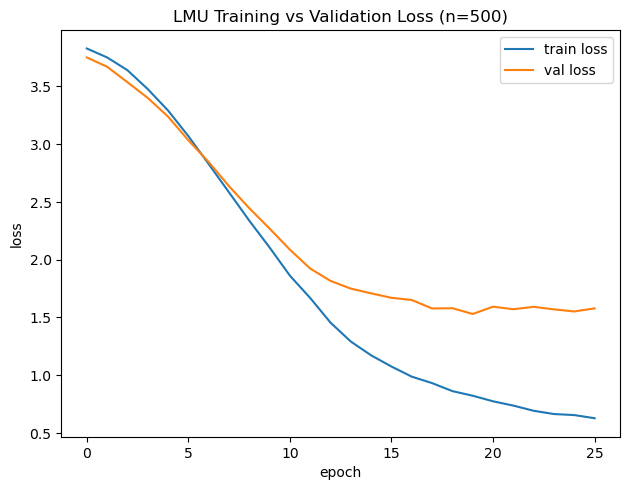

In [70]:
#Validation data
print("run_id is: ", run_id) 
print(f"LMU val_loss and val_acc for n={n}")
print(val_lmu) #val_loss, val_acc



#Training on the data epochs 
plt.figure()
plt.plot(df_lmu["epoch"], df_lmu["loss"], label="train loss")
plt.plot(df_lmu["epoch"], df_lmu["val_loss"], label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout()
plt.title(f"LMU Training vs Validation Loss (n={n})")

#save the plot 
plt.savefig(f"loss_curve_LMU_{run_id}.png", dpi=200, bbox_inches="tight")

plt.show()

## LSTM 

### LSTM Training 

In [67]:
#LSTM
cb_es_lstm = [
    K.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    K.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5), #multiply learning rate by 0.5 if doesn't improve, minimum learning rate 1e-5
] #monitor "val_mae" or "val_loss"

ckpt_lstm = K.callbacks.ModelCheckpoint(
    f"best_lstm_cls_{run_id}.weights.h5",
    monitor="val_loss", mode="min",
    save_best_only=True,
    save_weights_only=True,
)

csv_logger_lstm = K.callbacks.CSVLogger(f"lstm_train_log_{run_id}.csv", append=False)
callbacks_lstm = cb_es_lstm + [ckpt_lstm, csv_logger_lstm]
hist_lstm = lstm.fit(train_ds, validation_data=val_ds, epochs=1000, callbacks=callbacks_lstm)

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 202s 20s/step - acc: 0.0114 - loss: 3.9661 - val_acc: 0.0267 - val_loss: 3.8735 - learning_rate: 0.0020
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 97s 16s/step - acc: 0.0257 - loss: 3.8920 - val_acc: 0.0267 - val_loss: 3.8639 - learning_rate: 0.0020
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 95s 16s/step - acc: 0.0429 - loss: 3.8494 - val_acc: 0.0133 - val_loss: 3.8762 - learning_rate: 0.0020
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 94s 16s/step - acc: 0.0343 - loss: 3.8344 - val_acc: 0.0133 - val_loss: 3.8925 - learning_rate: 0.0020
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 94s 16s/step - acc: 0.0400 - loss: 3.7965 - val_acc: 0.0800 - val_loss: 3.8603 - learning_rate: 0.0020
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 96s 16s/step - acc: 0.0486 - loss: 3.7623 - val_acc: 0.0933 - val_loss: 3.8615 - learning_rate: 0.0020
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 94s 16s/step - acc: 0.0543 - loss: 3.7356 - val_acc: 0.0533 - val_loss: 3.8115 - learning_rate: 0.0020
Epoch 8/1000

### Load weights

In [71]:
# Reload + logs
lstm = build_lstm_with_dt_cls(T=T_max, cnn_out=32, lstm_units=32, use_cumtime=True)
lstm.load_weights(f"best_lstm_cls_{run_id}.weights.h5")
df_lstm = pd.read_csv(f"lstm_train_log_{run_id}.csv")

C:\Users\Maxime\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### LSTM Evaluate

In [72]:
#LSTM
val_lstm = lstm.evaluate(val_ds, verbose=0)

### LSTM Analysis 

In [73]:
lstm.summary()

Model: "lstm_with_dt_cls"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frames (InputLayer) │ (None, 1000, 28,  │          0 │ -                 │
│                     │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dts (InputLayer)    │ (None, 1000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 1000, 32)  │    101,632 │ frames[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cumtime (Lambda)    │ (None, 1000, 1)   │          0 │ dts[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_feats        │ (None, 1000, 34)  │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ dts[0][0],        │
│                     │                   │            │ cumtime[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_from_dt        │ (None, 1000)      │          0 │ dts[0][0]         │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │      8,576 │ concat_feats[0][… │
│                     │                   │            │ mask_from_dt[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 48)        │      1,584 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,792 (436.69 KB)

 Trainable params: 111,792 (436.69 KB)

 Non-trainable params: 0 (0.00 B)

run_id is:  n500_dt05-20
LSTM val_loss and val_acc for n=500
[2.0835912227630615, 0.3733333349227905]


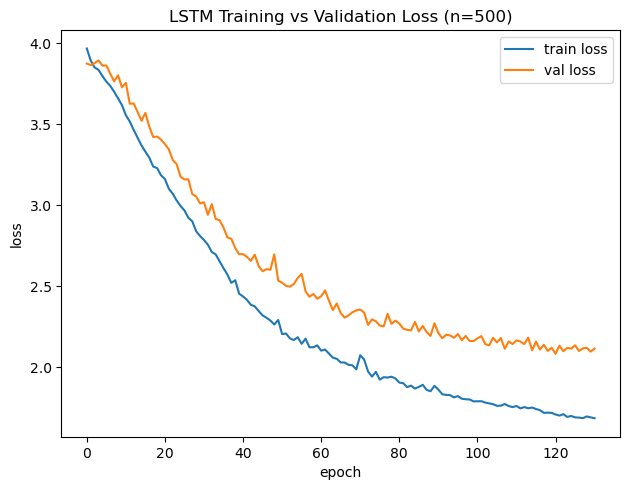

In [74]:
#Validation data
print("run_id is: ", run_id) 
print(f"LSTM val_loss and val_acc for n={n}")
print(val_lstm)


#Training on the data epochs 
plt.figure()
plt.plot(df_lstm["epoch"], df_lstm["loss"], label="train loss")
plt.plot(df_lstm["epoch"], df_lstm["val_loss"], label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout()
plt.title(f"LSTM Training vs Validation Loss (n={n})")

plt.savefig(f"loss_curve_LSTM_{run_id}.png", dpi=200, bbox_inches="tight")
plt.show()

## LMU V.S LSTM on Validation Data

In [75]:

print("run_id is: ", run_id) 
print("----------------------------------------")
print(f"LMU val_loss and val_acc for n={n}")
print(val_lmu) #val_loss, val_acc
print("----------------------------------------")
print(f"LSTM val_loss and val_acc for n={n}")
print(val_lstm)

run_id is:  n500_dt05-20
----------------------------------------
LMU val_loss and val_acc for n=500
[1.5304306745529175, 0.5866666436195374]
----------------------------------------
LSTM val_loss and val_acc for n=500
[2.0835912227630615, 0.3733333349227905]


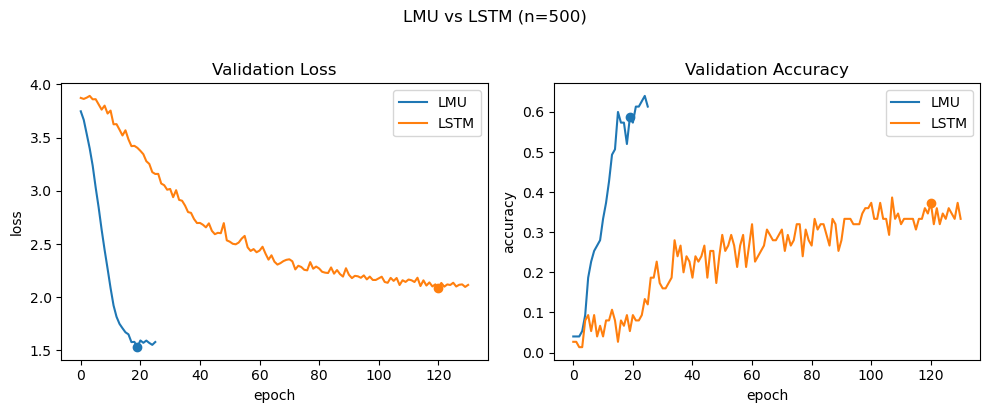

In [76]:
# find best-epoch indices (by val_loss)
i_best_lmu  = int(df_lmu["val_loss"].idxmin())
i_best_lstm = int(df_lstm["val_loss"].idxmin())

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# --- Left: val_loss
axes[0].plot(df_lmu["epoch"],  df_lmu["val_loss"],  label="LMU")
axes[0].plot(df_lstm["epoch"], df_lstm["val_loss"], label="LSTM")
axes[0].scatter(df_lmu.loc[i_best_lmu,  "epoch"], df_lmu.loc[i_best_lmu,  "val_loss"],  marker="o")
axes[0].scatter(df_lstm.loc[i_best_lstm, "epoch"], df_lstm.loc[i_best_lstm, "val_loss"], marker="o")
axes[0].set_title("Validation Loss")
axes[0].set_xlabel("epoch"); axes[0].set_ylabel("loss"); axes[0].legend()

# --- Right: val_acc
axes[1].plot(df_lmu["epoch"],  df_lmu["val_acc"],  label="LMU")
axes[1].plot(df_lstm["epoch"], df_lstm["val_acc"], label="LSTM")
axes[1].scatter(df_lmu.loc[i_best_lmu,  "epoch"], df_lmu.loc[i_best_lmu,  "val_acc"],  marker="o")
axes[1].scatter(df_lstm.loc[i_best_lstm, "epoch"], df_lstm.loc[i_best_lstm, "val_acc"], marker="o")
axes[1].set_title("Validation Accuracy")
axes[1].set_xlabel("epoch"); axes[1].set_ylabel("accuracy"); axes[1].legend()

fig.suptitle(f"LMU vs LSTM (n={n})", y=1.02)
fig.tight_layout()
fig.savefig(f"compare_lmu_lstm_{run_id}.png", dpi=200, bbox_inches="tight")
plt.show()


# Evaluate on Different Gaps 

In [77]:
# rebuild SLOW test with the exact same gaps
X_frames_slow, X_dts_slow, y_slow = rebuild_from_gaps(gaps_test, T_max=T_max, dt_min=0.10, dt_max=0.40, seed=42)  #or gaps_length[:300]
slow_ds = tf.data.Dataset.from_tensor_slices(((X_frames_slow, X_dts_slow), y_slow)).batch(64)

# Evaluate both models on the rebuilt data
loss_lmu, acc_lmu   = lmu.evaluate(slow_ds, verbose=0)
loss_lstm, acc_lstm = lstm.evaluate(slow_ds, verbose=0)

In [78]:
#print results 

print("Size of dataset", n)
print("Slow rebuild: dt_min = 0.10, dt_max = 0.40")
print(f"LMU  — loss: {loss_lmu:.4f}, acc: {acc_lmu:.4f}")
print(f"LSTM — loss: {loss_lstm:.4f}, acc: {acc_lstm:.4f}")

Size of dataset 500
Slow rebuild: dt_min = 0.10, dt_max = 0.40
LMU  — loss: 2.0407, acc: 0.5733
LSTM — loss: 3.4579, acc: 0.0800


In [79]:
# rebuild FAST test with the exact same gaps
X_frames_fast, X_dts_fast, y_fast = rebuild_from_gaps(gaps_test, T_max=T_max, dt_min=0.025, dt_max=0.10, seed=42)  #or gaps_length[:300]
fast_ds = tf.data.Dataset.from_tensor_slices(((X_frames_fast, X_dts_fast), y_fast)).batch(64)

# Evaluate both models on the rebuilt data
loss_lmu, acc_lmu   = lmu.evaluate(fast_ds, verbose=0)
loss_lstm, acc_lstm = lstm.evaluate(fast_ds, verbose=0)

In [80]:
#print results 

print("Size of dataset", n)
print("Fast rebuild: dt_min = 0.025, dt_max = 0.10")
print(f"LMU  — loss: {loss_lmu:.4f}, acc: {acc_lmu:.4f}")
print(f"LSTM — loss: {loss_lstm:.4f}, acc: {acc_lstm:.4f}")

Size of dataset 500
Fast rebuild: dt_min = 0.025, dt_max = 0.10
LMU  — loss: 2.0407, acc: 0.5733
LSTM — loss: 2.7019, acc: 0.2000


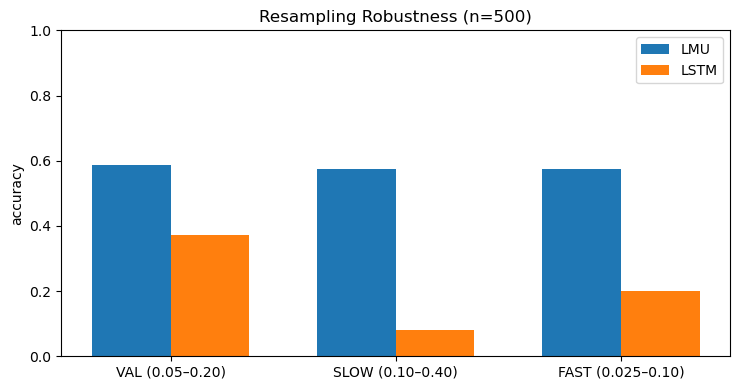

LMU  drop: VAL→SLOW 2.3%, VAL→FAST 2.3%
LSTM drop: VAL→SLOW 78.6%, VAL→FAST 46.4%


In [81]:
# plug in your numbers
val_lmu_acc   = 0.5866666436195374
slow_lmu_acc  = 0.5733
fast_lmu_acc  = 0.5733

val_lstm_acc  = 0.3733333349227905
slow_lstm_acc = 0.0800
fast_lstm_acc = 0.2000

# done plugging numbers
labels = ["VAL (0.05–0.20)", "SLOW (0.10–0.40)", "FAST (0.025–0.10)"]
lmu    = [val_lmu_acc,  slow_lmu_acc,  fast_lmu_acc]
lstm   = [val_lstm_acc, slow_lstm_acc, fast_lstm_acc]

x = np.arange(len(labels)); w = 0.35
fig, ax = plt.subplots(figsize=(7.5,4))
ax.bar(x - w/2, lmu,  width=w, label="LMU")
ax.bar(x + w/2, lstm, width=w, label="LSTM")
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=0)
ax.set_ylim(0, 1.0)
ax.set_ylabel("accuracy")
ax.set_title(f"Resampling Robustness (n={n})")
ax.legend()
fig.tight_layout()
fig.savefig(f"robustness_compare_{run_id}.png", dpi=200, bbox_inches="tight")
plt.show()

# print drops
def drop(a,b): return 100*(a-b)/max(a,1e-8)
print(f"LMU  drop: VAL→SLOW {drop(val_lmu_acc, slow_lmu_acc):.1f}%, VAL→FAST {drop(val_lmu_acc, fast_lmu_acc):.1f}%")
print(f"LSTM drop: VAL→SLOW {drop(val_lstm_acc, slow_lstm_acc):.1f}%, VAL→FAST {drop(val_lstm_acc, fast_lstm_acc):.1f}%")
